In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import array

2023-02-21 21:22:08.227044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 21:22:09.122572: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 21:22:11.142897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-02-21 21:22:11.143156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [2]:
la_2020 = pd.read_csv('./data/LA_pm10_2020.csv')
la_2021 = pd.read_csv('./data/LA_pm10_2021.csv')
la_2022 = pd.read_csv('./data/LA_pm10_2022.csv')

In [3]:
# subsetting
la_2020 = la_2020[['Date', 'Daily Mean PM10 Concentration']]
la_2021 = la_2021[['Date', 'Daily Mean PM10 Concentration']]
la_2022 = la_2022[['Date', 'Daily Mean PM10 Concentration']]

In [4]:
# converting all to datetime
la_2020['Date'] = pd.to_datetime(la_2020['Date'])
la_2021['Date'] = pd.to_datetime(la_2021['Date'])
la_2022['Date'] = pd.to_datetime(la_2022['Date'])

In [5]:
# # merging
# la_pm10 = pd.concat([la_2020, la_2021, la_2022])
# la_pm10.rename(columns = {'Daily Mean PM10 Concentration':'daily_pm10'}, inplace = True)

In [6]:
#merging
la_pm10 = pd.concat([la_2020, la_2021])
la_pm10.rename(columns = {'Daily Mean PM10 Concentration':'daily_pm10'}, inplace = True)
la_2022.rename(columns = {'Daily Mean PM10 Concentration':'daily_pm10'}, inplace = True)

In [7]:
# dropping null cols
la_pm10 = la_pm10.dropna()

In [8]:
la_pm10.head()

,Date,daily_pm10
0,2020-01-04,25
1,2020-01-10,20
2,2020-01-16,32
3,2020-01-22,21
4,2020-01-28,23


In [9]:
la_pm10.tail()

,Date,daily_pm10
983,2021-12-27,6
984,2021-12-28,6
985,2021-12-29,5
986,2021-12-30,4
987,2021-12-31,7


In [10]:
# # finding row with max pm10 value
# la_pm10.loc[(la_pm10['daily_pm10'] == max(la_pm10['daily_pm10']))]

In [11]:
# #normalizing
# la_pm10['daily_pm10'] = (la_pm10['daily_pm10'] - la_pm10['daily_pm10'].mean()) / la_pm10['daily_pm10'].std()

In [12]:
la_pm10.head()

,Date,daily_pm10
0,2020-01-04,25
1,2020-01-10,20
2,2020-01-16,32
3,2020-01-22,21
4,2020-01-28,23


Data Split

In [13]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(la_pm10[['daily_pm10']])

class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler) -> None:
        super().__init__()
        self.scaler = scaler
    def fit(self, X, y=None):
        X = check_array(X)
        return self
    def transform(self, X):
        return scaler.transform(X)

class DataSplitter(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        X = check_array(X)
        return self
    def transform(self, X):
        X = X.reshape(X.shape[0],).tolist()
        X = X[0:len(X)-1]
        x,y = split_sequence(X, 10)
        x = x.reshape((x.shape[0], x.shape[1], 1))
        return x,y

data_pipeline = Pipeline([
    ("scaler", DataScaler(scaler=scaler)),
    ("splitter", DataSplitter())
])

In [27]:
x_train, y_train = data_pipeline.transform(la_pm10[['daily_pm10']])

In [16]:
x_train

array([[[-0.8783455 ],
        [-0.9026764 ],
        [-0.84428224],
        ...,
        [-0.84428224],
        [-0.86861314],
        [-0.90754258]],

       [[-0.9026764 ],
        [-0.84428224],
        [-0.89781022],
        ...,
        [-0.86861314],
        [-0.90754258],
        [-0.8296837 ]],

       [[-0.84428224],
        [-0.89781022],
        [-0.88807786],
        ...,
        [-0.90754258],
        [-0.8296837 ],
        [-0.9756691 ]],

       ...,

       [[-0.90754258],
        [-0.88807786],
        [-0.8540146 ],
        ...,
        [-0.9756691 ],
        [-0.98053528],
        [-0.97080292]],

       [[-0.88807786],
        [-0.8540146 ],
        [-0.83941606],
        ...,
        [-0.98053528],
        [-0.97080292],
        [-0.97080292]],

       [[-0.8540146 ],
        [-0.83941606],
        [-0.8540146 ],
        ...,
        [-0.97080292],
        [-0.97080292],
        [-0.9756691 ]]])

In [17]:
y_train

array([-0.8296837 , -0.9756691 , -0.94647202, ..., -0.97080292,
       -0.9756691 , -0.98053528])

In [19]:
# define model
n_steps = 10
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2023-02-21 21:22:26.025294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 21:22:26.032485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 21:22:26.033054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 21:22:26.033646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [20]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [21]:
model.fit(x_train, y_train, epochs=200, verbose=0)

2023-02-21 21:22:33.582817: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


KeyboardInterrupt: 

In [ ]:
model.save('models/lstm_model_1.h5')

In [ ]:
# import joblib
# from joblib import Parallel, delayed

# joblib.dump(model, './models/keras_lstm_1.pkl')

In [22]:
from keras.models import load_model
model = load_model('./models/lstm_model_1.h5')

In [46]:
yhat = model.predict(la_2022['daily_pm10'][0:100], verbose=0)

In [42]:
x_test, y_test = data_pipeline.transform(la_pm10[['daily_pm10']][0:100])

In [48]:
y_test

array([-0.8296837 , -0.9756691 , -0.94647202, -0.96593674, -0.85888078,
       -0.756691  , -0.8053528 , -0.67883212, -0.8783455 , -0.79075426,
       -0.83454988, -0.74695864, -0.6593674 , -0.77128954, -0.83454988,
       -0.79075426, -0.26034063, -0.5377129 , -0.63017032, -0.68856448,
       -0.5620438 , -0.79075426, -0.80048662, -0.87347932, -0.62043796,
       -0.82481752, -0.8540146 , -0.7810219 , -0.77615572, -0.92214112,
       -0.8783455 , -0.81021898, -0.79562044, -0.77128954, -0.95620438,
       -0.94160584, -0.9270073 , -0.93187348, -0.9026764 , -0.9270073 ,
       -0.93187348, -0.9026764 , -0.89781022, -0.91240876, -0.91727494,
       -0.91727494, -0.91240876, -0.8783455 , -0.83454988, -0.79562044,
       -0.86374696, -0.97080292, -0.96107056, -0.96593674, -0.88321168,
       -0.9270073 , -0.92214112, -0.93673966, -0.91727494, -0.88807786,
       -0.79562044, -0.86861314, -0.93673966, -0.8540146 , -0.9026764 ,
       -0.93187348, -0.96593674, -0.93673966, -0.90754258, -0.91

In [44]:
pred = model.predict(x_test, verbose=0)

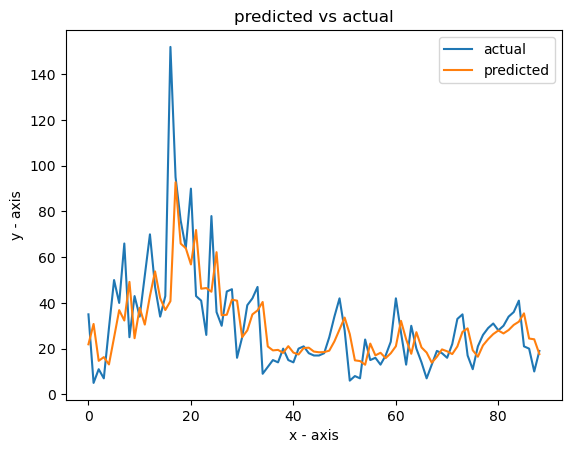

In [63]:
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label = "actual")
plt.plot(scaler.inverse_transform(pred), label = "predicted")

plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('predicted vs actual')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(pred))

307.0855368613639